In [1]:
#Code for improved fMRI-bias learning
#OV Jan 2021
####IMPORTS
import tensorflow as tf
import socket
import neurite as ne
import neurite_sandbox as nes
import numpy as np
import keras
import freesurfer as fs
from keras.optimizers import Adam
from keras import backend as K
from keras import layers as KL
#Load my own functions
import my_utils as utils
#from freesurfer import deeplearn as fsd
#OV: This imports all the local settings, e.g. subjects etc. from the header.py and netparms.py file, make your changes in there as needed
from netparms import *
from header_better import *
import losspad
#OV add matplotlib for plotting and cross checks
#import matplotlib.pyplot as plt
import random as rd
import string as string
####END IMPORTS
tf.__version__

/usr/pubsw/packages/python/anaconda3-2019.03/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Issue loading cv2


'2.4.1'

READ IN DATA


In [2]:
surfs_sphere   = np.load('data_train/surfs_sphere.npy',allow_pickle = "true")
surfs_pials    = np.load('data_train/surfs_pials.npy',allow_pickle = "true")
surfs_inflated = np.load('data_train/surfs_inflated.npy',allow_pickle = "true")
labels_cortex  = np.load('data_train/labels_cortex.npy',allow_pickle = "true")
maps_func      = np.load('data_train/maps_func.npy',allow_pickle = "true")
maps_angles    = np.load('data_train/maps_angles.npy',allow_pickle = "true")
maps_thickness = np.load('data_train/maps_thickness.npy',allow_pickle = "true")
maps_angio     = np.load('data_train/maps_angio.npy',allow_pickle = "true")
NumFuncs       = np.load('data_train/NumFuncs.npy',allow_pickle = "true")
#%whos

In [3]:

#test=angio.copy()
#n,bins,patches = plt.hist(test.ravel(), bins = 'auto', alpha = 0.4, label = 'Normalised thickness')
#labels_cortex.shape
#labels_cortex = np.ones(labels_cortex.shape)

Define in and ouput data and assign a cortex label if wanted:

In [4]:
numInputs = 1
#Assign in- and output data
inputs  = []
outputs = [] 
for sno, subject in enumerate(subjects): 
   for hno, hemi in enumerate(hemis):
      for rn, func_runs in enumerate(Func_runs):
         if numInputs > 1:
            #We don't have a full set of runs for all subjects, some didn't register well
            #also multiply by cortex label 
            tmp_in = np.zeros(input_shape)
            try:
               outputs.append(np.multiply(maps_func[sno][hno][rn].data,labels_cortex[sno][hno]))
               tmp_in[...,0] = np.multiply(maps_thickness[sno][hno].data,labels_cortex[sno][hno])
               tmp_in[...,1] = np.multiply(maps_angio[sno][hno].data,labels_cortex[sno][hno])
               tmp_in[...,2] = np.multiply(maps_angles[sno][hno][rn].data,labels_cortex[sno][hno])
               inputs.append(tmp_in)
            except IndexError:
               continue
         elif numInputs == 1:
            try: 
               inputs.append(np.multiply(maps_func[sno][hno][rn].data,labels_cortex[sno][hno]))
               #outputs.append(maps_angio[sno][hno].data)
               outputs.append(np.multiply(maps_thickness[sno][hno].data,labels_cortex[sno][hno]))
               #outputs.append(maps_angles[sno][hno][rn].data) 
               #print("Single input")
            except IndexError:
               continue  
print(maps_func[0][0][0].shape)
print(NumFuncs)

(256, 512)
[16.000 16.000 16.000 10.000 16.000 14.000 14.000 12.000 0.000 0.000]


Circuarly leave-on-out strategy for training and testing

subject: sub-MSC01
input dimensions training: (97, 256, 512, 1) and testing (16, 256, 512, 1) 
output dimensions: training (97, 256, 512, 1) and testing: (16, 256, 512, 1) 
using masked loss
Epoch 1/2
1024/1024 [==============================] - 275s 222ms/step - loss: 2.4207 - accuracy: 0.0288 - val_loss: 0.3965 - val_accuracy: 0.0000e+00
Epoch 2/2
1024/1024 [==============================] - 207s 203ms/step - loss: 0.3230 - accuracy: 3.8991e-04 - val_loss: 0.3248 - val_accuracy: 0.0000e+00


TypeError: imshow() missing 1 required positional argument: 'X'

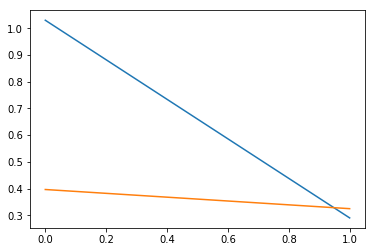

In [5]:
#Define training settings
epochs        = 2
learning_rate = 1e-3
use_mask      = True

#Initialize
loss        = []
val_loss    = []
plt.figure()

NumFuncs    = NumFuncs.astype(int)
CumSumFuncs = np.cumsum(NumFuncs)
for subj, subject in enumerate(subjects):
   numInputs = 1
   target_shape = (maps_func[0][0][0].shape+(1,)) 
   input_shape  = (maps_func[0][0][0].shape+(numInputs,))
   print('subject: %s' %(subject))
  
   #OV: neuron (ne) expects another channel, but here we just have one number (the thickness or fmri derived parameter), 
   #maybe replace that with the time series itself? for now we just add np.newaxis as an empty channel
   #Assign training and testing data depending on subject
   if numInputs > 1: 
      #print(CumSumFuncs[subj-1],CumSumFuncs[subj])
      if (subj > 0 and subj<(len(subjects)-1)):
        xtrain    = np.array(np.concatenate((inputs[0 : CumSumFuncs[subj-1]],\
                                        inputs[CumSumFuncs[subj]:-1])))
        ytrain    = np.array(np.concatenate((outputs[0 : CumSumFuncs[subj-1]],\
                                        outputs[CumSumFuncs[subj]:-1])))[...,np.newaxis]
        xtest     = np.array(inputs[CumSumFuncs[subj-1] : CumSumFuncs[subj]])
        ytest     = np.array(outputs[CumSumFuncs[subj-1] : CumSumFuncs[subj]])[...,np.newaxis]
      elif subj == 0:
        xtrain    = np.array(inputs[NumFuncs[1]:-1])
        ytrain    = np.array(outputs[NumFuncs[1]:-1])[...,np.newaxis]
        xtest     = np.array(inputs[0:NumFuncs[0]])
        ytest     = np.array(outputs[0:NumFuncs[0]])[...,np.newaxis]
      elif subj == (len(subjects)-1):
        xtrain    = np.array(inputs[0:-NumFuncs[subj]])
        ytrain    = np.array(outputs[0:-NumFuncs[subj]])[...,np.newaxis]
        xtest     = np.array(inputs[NumFuncs[subj-1]:NumFuncs[subj]])
        ytest     = np.array(outputs[NumFuncs[subj-1]:NumFuncs[subj]])[...,np.newaxis]
                                     
   elif numInputs == 1:
      #print(CumSumFuncs[subj-1],CumSumFuncs[subj])
      if (subj > 0 and subj<(len(subjects)-1)):
        xtrain    = np.array(np.concatenate((inputs[0 : CumSumFuncs[subj-1]],\
                                        inputs[CumSumFuncs[subj]:-1])))[...,np.newaxis]
        ytrain    = np.array(np.concatenate((outputs[0 : CumSumFuncs[subj-1]],\
                                        outputs[CumSumFuncs[subj]:-1])))[...,np.newaxis]
        xtest     = np.array(inputs[CumSumFuncs[subj-1] : CumSumFuncs[subj]])[...,np.newaxis]
        ytest     = np.array(outputs[CumSumFuncs[subj-1] : CumSumFuncs[subj]])[...,np.newaxis]
      elif subj == 0:
        xtrain    = np.array(inputs[NumFuncs[1]:-1])[...,np.newaxis]
        ytrain    = np.array(outputs[NumFuncs[1]:-1])[...,np.newaxis]
        xtest     = np.array(inputs[0:NumFuncs[0]])[...,np.newaxis]
        ytest     = np.array(outputs[0:NumFuncs[0]])[...,np.newaxis]
      elif subj == (len(subjects)-1):
        xtrain    = np.array(inputs[0:CumSumFuncs[subj-2]])[...,np.newaxis]
        ytrain    = np.array(outputs[0:CumSumFuncs[subj-2]])[...,np.newaxis]
        xtest     = np.array(inputs[CumSumFuncs[subj-1]:CumSumFuncs[subj]])[...,np.newaxis] 
        ytest     = np.array(outputs[CumSumFuncs[subj-1]:CumSumFuncs[subj]])[...,np.newaxis]     

   print('input dimensions training: %s and testing %s ' %(xtrain.shape, xtest.shape))
   print('output dimensions: training %s and testing: %s ' %(ytrain.shape, ytest.shape))
    
   #Set up model
   K.clear_session()
   model = ne.models.unet(nb_features, target_shape, nb_depth, (3,3), 1, nb_conv_per_level = nb_conv_per_level, \
                          batch_norm = -1, final_pred_activation = 'linear')
   #make directory for callbacks 
   model_dir = 'model_dir'
   RandomName=''.join(rd.sample(string.ascii_lowercase,5))
   os.mkdir(os.path.join('/cluster/visuo/users/olivia/Projects/DeepBias/Better_code',model_dir,RandomName))
   save_file_name = os.path.join(model_dir, RandomName, '{epoch:02d}.h5') 
   save_callbacks = tf.keras.callbacks.ModelCheckpoint(save_file_name)
   #subclass of lr_callback written by Bruce. If loss explodes it detects that and falls back to a checkpoint
   lr_callbacks   = nes.tf.callbacks.ReduceLRWithModelCheckpointAndRecovery(save_file_name, \
                                                                            monitor='loss', \
                                                                            verbose=1, \
                                                                            cooldown=10, \
                                                                            factor=.5, \
                                                                            patience=100, \
                                                                            thres=.2, \
                                                                            save_weights_only=True, \
                                                                            min_lr=1e-7)

   sphereloss = losspad.spherical_loss(target_shape[0:2],pad=pad) #_no_pad[0:2],pad=pad)
   if use_mask == False:
       print('NOT using masked loss')
       #OV changed to tensorflow.keras bc it gave attribute error otherwise
       model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='MSE', metrics = ['accuracy'])
   else:
       print('using masked loss')
       model.compile(optimizer=Adam(lr=learning_rate), loss=utils.masked_MSE_loss , metrics = ['accuracy'])

   #Fit
   #dg = generator(xtrain[...,np.newaxis], ytrain, 8,augment_noise=.3)
   dg    = utils.generator(xtrain, ytrain, 8, augment_noise=.3)
   fhist = model.fit(dg, steps_per_epoch=1024, epochs=epochs, \
                     validation_data= (xtest, ytest), \
                     verbose=1, \
                     callbacks=[lr_callbacks])

   #Saving information for each CNN (i.e. each subject/cross valdiation cycle)
   loss.append(fhist.history['loss'])
   val_loss.append(fhist.history['val_loss'])
   ep = np.arange(epochs)
   plt.plot(ep,fhist.history['loss'], label=('train loss ' + subject))
   plt.plot(ep,fhist.history['val_loss'],label = ('val loss ' + subject))
   plt.imshow()

   #PREDICT
   #Test on unseen data from unseen subject
   yp                 = model.predict(xtest)
   #Take out non cortex labeled areas
   yp[xtest==0]       = 0

   #Mean differene between predicition and truth
   print('Prediciting error is ' + str(np.absolute(ytest-yp).mean()))
   Prediction_err.append(np.absolute(ytest-yp).mean())

   #Error for scrambled prediction, "null output error"
   rand                  = np.random.shuffle(ytest.copy().squeeze())
   NullOutput_err.append(np.absolute(ytest.squeeze()-rand).mean())
   print('Random error is ' + str(np.absolute(ytest.squeeze()-rand).mean()))

   #Error for scrambled predictor (input), "null input error"
   bonkers               = np.random.shuffle(xtest.copy().squeeze())
   bonkers               = np.array(bonkers)[np.newaxis,...,np.newaxis]
   yp_bonkers            = model.predict(bonkers)
   NullInput_err.append(np.absolute(yp_bonkers.squeeze() - ytest.squeeze()).mean())
   print('Error between bonkers input predictino and truth is ' + \
          str(np.absolute(yp_bonkers.squeeze() - ytest.squeeze()).mean()))
   


In [ ]:
#model.save(os.path.join(model_dir, RandomName) + '/final_model.h5')
#trained_model = tf.keras.models.load_model(os.path.join(model_dir,RandomName) + '/final_model.h5'

#Test on unseen data from unseen subject
yp                 = model.predict(xtest)
#Take out non cortex labeled areas
yp[xtest==0]       = 0

#Mean differene between predicition and truth
print('Prediciting error is ' + str(np.absolute(ytest-yp).mean()))
Prediction_err.append(np.absolute(ytest-yp).mean())

#Error for scrambled prediction, "null output error"
rand                  = np.random.shuffle(ytest.copy().squeeze())
NullOutput_err.append(np.absolute(ytest.squeeze()-rand).mean())
print('Random error is ' + str(np.absolute(ytest.squeeze()-rand).mean()))

#Error for scrambled predictor (input), "null input error"
bonkers               = np.random.shuffle(xtest.copy().squeeze())
bonkers               = np.array(bonkers)[np.newaxis,...,np.newaxis]
yp_bonkers            = model.predict(bonkers)
NullInput_err.append(np.absolute(yp_bonkers.squeeze() - ytest.squeeze()).mean())
print('Error between bonkers input predictino and truth is ' + \
      str(np.absolute(yp_bonkers.squeeze() - ytest.squeeze()).mean()))



#Histogram of predicition error for orientation (not in percent)
fig = plt.figure()
tmp = ytest-yp
tmp = tmp[~np.isnan(tmp)]
tmp = tmp[~np.isinf(tmp)]
tmp2 = ytest.squeeze()-rand
tmp2 = tmp2[~np.isnan(tmp2)]
tmp2 = tmp2[~np.isinf(tmp2)] 
n,bins,patches = plt.hist(tmp, bins = 'auto', alpha = 0.4, label = 'Prediction')
plt.hist(tmp2, bins = bins, alpha = 0.4, label = 'Randomised orientation')
plt.xlabel('prediction error [\deg]')
plt.ylabel('counts')
plt.xlim(-90,90)
#plt.legend()
plt.title('Prediction error of orientation from fMRI')
plt.show()

In [ ]:
sphere      = surfs_sphere[-1][-1]
pial_disp   = surfs_inflated[-1][-1]
fv          = fs.Freeview()
truth       = sphere.sample_parameterization(ytest.squeeze())
overlay     = fv.OverlayTag(truth, name='truth')#, threshold=(.0, 90)) 
overlays    = [overlay]
prediction  = sphere.sample_parameterization(yp.squeeze())
overlay     = fv.OverlayTag(prediction, name='prediction')#, threshold=(0, 90)) 
overlays.append(overlay)
difference  = sphere.sample_parameterization(ytest.squeeze()-yp.squeeze())
overlay     = fv.OverlayTag(difference, name='difference')#, threshold=(-50,50)) 
overlays.append(overlay)


fv.surf(pial_disp, overlay=overlays)
fv.show(threads=20)

#fv.show.__code__.co_varnames

#Plot model overview
#keras.utils.plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)

Plot binned dependencies on features

In [ ]:
import itertools
from scipy.stats import binned_statistic

tmpfunc      = list(itertools.chain(*maps_func[:][:][0][:]))
tmpfunc      = list(itertools.chain(*tmpfunc))
tmpangles    = list(itertools.chain(*maps_angles[:][:][0][:]))
tmpangles    = list(itertools.chain(*tmpangles))
tmpfunc      = np.array(tmpfunc)
tmpangles    = np.array(tmpangles)
tmpfunc      = tmpfunc.ravel()
tmpangles    = tmpangles.ravel()
tmpangio     = maps_angio.ravel()
tmpthick     = maps_thickness.ravel()

#Remove outliers from functional MRI
quant        = np.quantile(tmpfunc, [.1, .9])
mask         = np.ones(tmpfunc.shape)
mask[(tmpfunc>quant[1]) | (tmpfunc<quant[0])] = None 
tmpfunc      = tmpfunc[~np.isnan(mask)]
tmpangles    = tmpangles[~np.isnan(mask)]
tmpthick     = tmpthick[~np.isnan(mask)]
tmpangio     = tmpangio[~np.isnan(mask)]
plt.hist(tmpangio)

print(tmp.shape, tmp2.shape)
print(tmp,quant,mask,np.count_nonzero(mask) )
mean_angio = binned_statistic(tmpangio, tmpfunc, statistic='mean', bins=100, range=(0,2))
mean_thick = binned_statistic(tmpthick, tmpfunc, statistic='mean', bins=100, range=(0,5))
mean_angle = binned_statistic(tmpangles, tmpfunc, statistic='mean', bins=100, range=(0,90))
std_angio = binned_statistic(tmpangio, tmpfunc, statistic='std', bins=100, range=(0,2))
std_thick = binned_statistic(tmpthick, tmpfunc, statistic='std', bins=100, range=(0,5))
std_angle = binned_statistic(tmpangles, tmpfunc, statistic='std', bins=100, range=(0,90))

plt.figure()
plt.errorbar(mean_angio.bin_edges[:-1],mean_angio.statistic, label='fMRI binned by angio')
plt.figure()
plt.scatter(mean_thick.bin_edges[:-1],mean_thick.statistic, label='fMRI binned by thickness')
plt.figure()
plt.scatter(mean_angle.bin_edges[:-1],mean_angle.statistic, label='fMRI binned by angles')